# Exploring Venues in Boston, MA

## Table of Contents

## Introduction

The aim of this Capston project is to discover the venues in Boston, Massachusetts according to the ratings and average costs(prices). 
In this notebook, we will use Foursquare API and Zomaton API to select the desired venues.

The two primary factors that people choose a place to eat when took a tour in a new city are venues ratings and their budget.
This will also be the two main factors that will be taken into consideration during this project.

## Data Collecting

* **Foursquare API:** Fetch venues in Boston.
* **Zomato API:** The Zomato API provides information about various venues including the **complete address**, **user ratings**, **price range** and a lot more.

## About Boston

Boston is the capital and most populous city of the Commonwealth of Massachusetts in the United States, the city proper covers 49 square miles with an estimated population of 692,600 in 2019, also making it the most populous city in New England.
The city is the economic and cultural anchor of a substantially larger metropolitan area known as Greater Boston, a metropolitan statistical area (MSA) home to a census-estimated 4.8 million people in 2016 and ranking as the **tenth-largest** such area in the country.

In [1]:
# The coordinate of Boston
BOS_LAT = 42.361145
BOS_LNG = -71.057083

print('The geograpical coordinates of Boston are {}, {}.'.format(BOS_LAT, BOS_LNG))

The geograpical coordinates of Boston are 42.361145, -71.057083.


## Brief View of Downton Boston

Let's use the **folium** library to create a complete map zoomed on Boston. We'll also plot a marker on the coordinates we just identified above. 

In [2]:
!pip install folium
import folium

In [3]:
boston_map = folium.Map(location = [BOS_LAT, BOS_LNG], zoom_start = 13)
folium.Marker([BOS_LAT, BOS_LNG]).add_to(boston_map)
boston_map


## FourSquare API

We are using the Explore API from the FourSquare API which allows us to find venue recommendations within a pre-defined radius from the given coordinates. 

In [4]:
FS_client_id = 'F5SJGDY2W2KNQLJ552UA5BSJL3Y3P1MIPLG3OGUHNSZ4FSGC'
FS_client_secret = 'C2B4XKP4LMUSFEXNHIY0IXX0TCTGLNHLBX5OHZODJR4NOBFL'
Radius = 3000 # radius is 1 kilometers
No_Venues = 100
Version = '20200601'

Using the function called 'get_category_type' we've already created during the previous lab.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FS_client_id, 
                                                                        FS_client_secret, 
                                                                        Version, 
                                                                        BOS_LAT, 
                                                                        BOS_LNG, 
                                                                        Radius,
                                                                        No_Venues,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    #print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, Radius/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Total 236 venues fetched


take a look at our data

In [7]:
foursquare_venues.head(10)

,name,categories,lat,lng
0,North End Park,Park,42.362488,-71.056477
1,Saus Restaurant,Belgian Restaurant,42.361076,-71.057054
2,Quincy Market,Historic Site,42.360106,-71.054881
3,The Rose Kennedy Greenway - Mothers Walk,Park,42.362640,-71.056407
4,Faneuil Hall Marketplace,Historic Site,42.359978,-71.056410
5,Neptune Oyster,Seafood Restaurant,42.363237,-71.056139
6,Boston Public Market,Market,42.361950,-71.057466
7,Tatte Bakery & Cafe,Bakery,42.358451,-71.057981
8,Bricco Salumeria and Pasta Shop,Deli / Bodega,42.363071,-71.055041
9,Polcari's Coffee,Gourmet Shop,42.364125,-71.055513


## Zomato API

Similar to FourSquare API, Zomato API also requires a user key to search for any given venue based on certain search filter.

In [8]:
headers = {'user-key': 'bd0c6fcbc7eebeadc551404686d97655'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [9]:
boston_map = folium.Map(location = [BOS_LAT, BOS_LNG], zoom_start = 15)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(boston_map)  

boston_map.save("map/Venues by Foursquare.html")
boston_map

In [10]:
zomato_venues.head(10)

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Gigi Gelateria,42.3629100000,-71.0563340000,25.0,2.0,2.6,"64 Cross st, Boston 02113"
1,Saus,42.3613000000,-71.0569600000,30.0,3.0,4.2,"33 Union Street, Near Faneuil Hall 02108"
2,Anthem Kitchen + Bar,42.3598650000,-71.0552400000,40.0,3.0,3.9,"101 S Market Street, Boston 02109"
3,Black Rose,42.3594370000,-71.0535930000,25.0,2.0,4.2,"160 State Street, Boston 02109"
4,Gourmet India,42.3600300000,-71.0562300000,0.0,1.0,3.0,1 Faneuil Hall Square
5,Neptune Oyster,42.3633770000,-71.0557400000,70.0,4.0,4.5,"63 Salem St, Boston 02113"
6,Point,42.3617030000,-71.0569170000,50.0,4.0,2.0,"147 Hanover Street, Boston 02108"
7,PAUL,42.3580780000,-71.0578762000,0.0,1.0,0,"201 Washington Street, Boston 02201"
8,Bricco Salumeria & Pasta Shop,42.3629170000,-71.0549540000,0.0,1.0,0,"11 Board Alley, Boston 02113"
9,Polcari's Coffee,42.3640150000,-71.0554140000,25.0,2.0,3.7,"105 Salem St, Boston 02113"


In [11]:
boston_map = folium.Map(location = [BOS_LAT, BOS_LNG], zoom_start = 13)
for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label)
    
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(boston_map)  

boston_map.save("map/Venues by Zomato.html")
boston_map

## Data Cleaning

We collected data from different source, it is important for us to combine the overlapping information and as well as removing some unnecessary stuff.

As the above two maps indicated, there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping. However, there are others where the data does not match.

To combine the two datasets, double check that the latitude and longitude values of each corresponding venue match. Thus, round both the latitude and longitude values up to 4 decimal places. Then, calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are the same.

In [12]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [13]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [14]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Saus Restaurant,Belgian Restaurant,42.3611,-71.0571,Saus,42.3613,-71.0570,30.0,3.0,4.2,"33 Union Street, Near Faneuil Hall 02108",0.0002,0.0001
1,Quincy Market,Historic Site,42.3601,-71.0549,Anthem Kitchen + Bar,42.3599,-71.0552,40.0,3.0,3.9,"101 S Market Street, Boston 02109",-0.0002,-0.0003
2,Faneuil Hall Marketplace,Historic Site,42.3600,-71.0564,Gourmet India,42.3600,-71.0562,0.0,1.0,3.0,1 Faneuil Hall Square,0.0000,0.0002
3,Neptune Oyster,Seafood Restaurant,42.3632,-71.0561,Neptune Oyster,42.3634,-71.0557,70.0,4.0,4.5,"63 Salem St, Boston 02113",0.0002,0.0004
4,Tatte Bakery & Cafe,Bakery,42.3585,-71.0580,PAUL,42.3581,-71.0579,0.0,1.0,0,"201 Washington Street, Boston 02201",-0.0004,0.0001
5,Bricco Salumeria and Pasta Shop,Deli / Bodega,42.3631,-71.0550,Bricco Salumeria & Pasta Shop,42.3629,-71.0550,0.0,1.0,0,"11 Board Alley, Boston 02113",-0.0002,0.0000
6,Polcari's Coffee,Gourmet Shop,42.3641,-71.0555,Polcari's Coffee,42.3640,-71.0554,25.0,2.0,3.7,"105 Salem St, Boston 02113",-0.0001,0.0001
7,Regina Pizzeria,Pizza Place,42.3654,-71.0569,Regina Pizzeria,42.3654,-71.0569,75.0,4.0,4.5,"11 1/2 Thacher St, Boston 02113",0.0000,0.0000
8,Galleria Umberto,Pizza Place,42.3639,-71.0544,Galleria Umberto,42.3638,-71.0544,25.0,2.0,4.7,"289 Hanover Street, Boston 02113",-0.0001,0.0000
9,Sam LaGrassa's,Sandwich Place,42.3569,-71.0600,Sam Lagrassa's,42.3569,-71.0598,25.0,2.0,4.4,"44 Province Street, Boston 02108",0.0000,0.0002


In [15]:
selected_venues = selected_venues.drop([24, 53, 55, 77, 91, 95]).reset_index(drop=True)
selected_venues.head()

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Saus Restaurant,Belgian Restaurant,42.3611,-71.0571,Saus,42.3613,-71.0570,30.0,3.0,4.2,"33 Union Street, Near Faneuil Hall 02108",0.0002,0.0001
1,Quincy Market,Historic Site,42.3601,-71.0549,Anthem Kitchen + Bar,42.3599,-71.0552,40.0,3.0,3.9,"101 S Market Street, Boston 02109",-0.0002,-0.0003
2,Faneuil Hall Marketplace,Historic Site,42.3600,-71.0564,Gourmet India,42.3600,-71.0562,0.0,1.0,3.0,1 Faneuil Hall Square,0.0000,0.0002
3,Neptune Oyster,Seafood Restaurant,42.3632,-71.0561,Neptune Oyster,42.3634,-71.0557,70.0,4.0,4.5,"63 Salem St, Boston 02113",0.0002,0.0004
4,Tatte Bakery & Cafe,Bakery,42.3585,-71.0580,PAUL,42.3581,-71.0579,0.0,1.0,0,"201 Washington Street, Boston 02201",-0.0004,0.0001


Then we'll select the venue name from Zomato API. Also we can get the average price for one person by dividing the column 'price_for_two' by 2 and we could also remove some unnecessary items.

In [16]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [17]:
selected_venues.head(10)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Belgian Restaurant,Saus,42.3613,-71.0570,3.0,4.2,"33 Union Street, Near Faneuil Hall 02108",15.0
1,Historic Site,Anthem Kitchen + Bar,42.3599,-71.0552,3.0,3.9,"101 S Market Street, Boston 02109",20.0
2,Historic Site,Gourmet India,42.3600,-71.0562,1.0,3.0,1 Faneuil Hall Square,0.0
3,Seafood Restaurant,Neptune Oyster,42.3634,-71.0557,4.0,4.5,"63 Salem St, Boston 02113",35.0
4,Bakery,PAUL,42.3581,-71.0579,1.0,0,"201 Washington Street, Boston 02201",0.0
5,Deli / Bodega,Bricco Salumeria & Pasta Shop,42.3629,-71.0550,1.0,0,"11 Board Alley, Boston 02113",0.0
6,Gourmet Shop,Polcari's Coffee,42.3640,-71.0554,2.0,3.7,"105 Salem St, Boston 02113",12.5
7,Pizza Place,Regina Pizzeria,42.3654,-71.0569,4.0,4.5,"11 1/2 Thacher St, Boston 02113",37.5
8,Pizza Place,Galleria Umberto,42.3638,-71.0544,2.0,4.7,"289 Hanover Street, Boston 02113",12.5
9,Sandwich Place,Sam Lagrassa's,42.3569,-71.0598,2.0,4.4,"44 Province Street, Boston 02108",12.5


The dataframe above will be the one we are using for the later analysis.
Also as shown above, some historical sites has 0 average price, we will also remove those sites for better analysis.

In [18]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 79


## Methodology

This project is using both FourSquare API and Zomato API to fetch data about Boston local venues in order to provide a better venues referencing for visitors based on the rating and pricing which could be usually treated as two main factors for venues selection.


### Data Collection

The corresponding data was retrieved from two APIs above, due to the limitation of the free developers account(1000 calls/day) and density of venues in downtown Boston, here we are using a radius of 5 kilometers from the center of downtown Boston. In addition to the coordinates and basic information fetched using Foursquare API, the pricing information was also retrieved using Zomato API. 

What we'll provide through those data is that identify where most popular venues are located so visitors can have much more fun without going to a lot of places. Also we'll be plotting those highly rated and poorly rated places on the map.

### Analysis 


<BarContainer object of 43 artists>

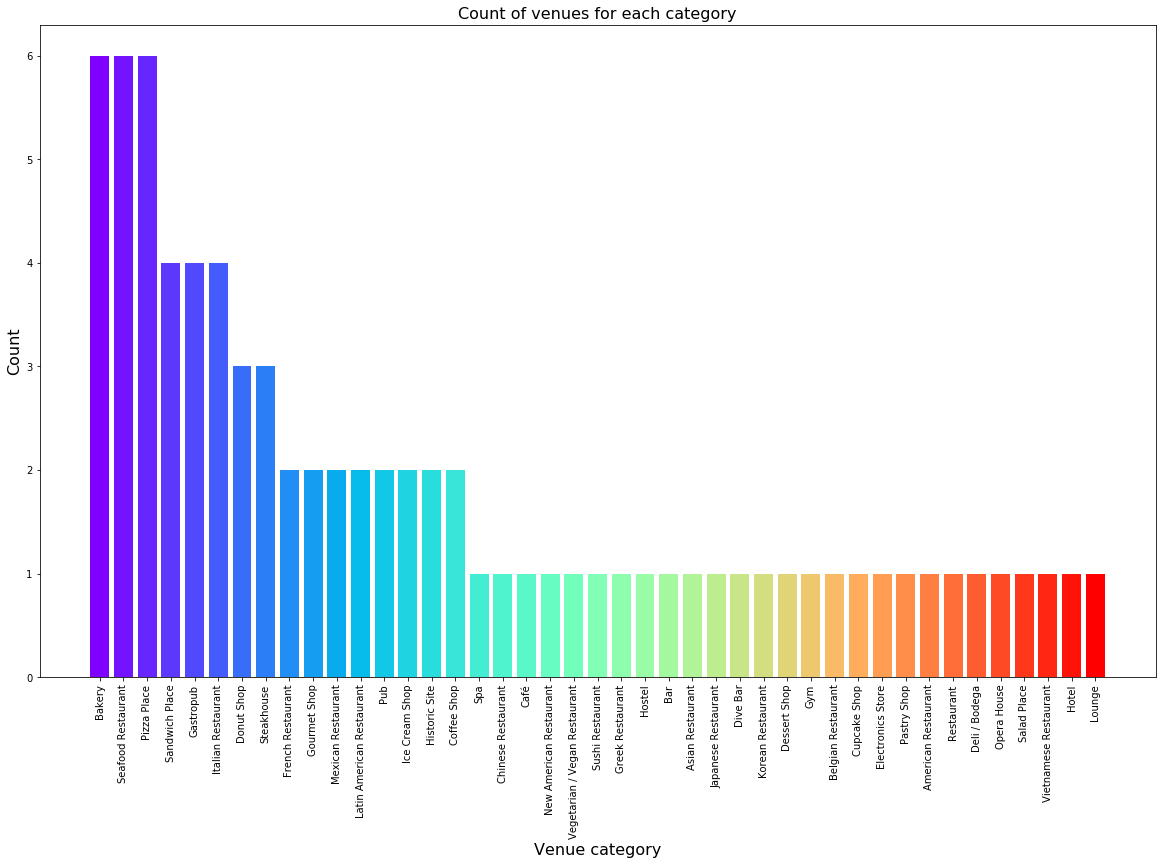

In [19]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues for each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As indicated by the category composition, the top 3 favorite category is bakery shop,seafood restaurant and Italian Restaurant. Boston is a habour city where downtown area is a the place called little Italy, that could explain the why distribution favors seafood and Italian food. 

### Ratings

Rating of a venue is an important factor when a visitor decides whether it is worth it to visit.  We'll first see what is the average rating for all the venues in this area. Then, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

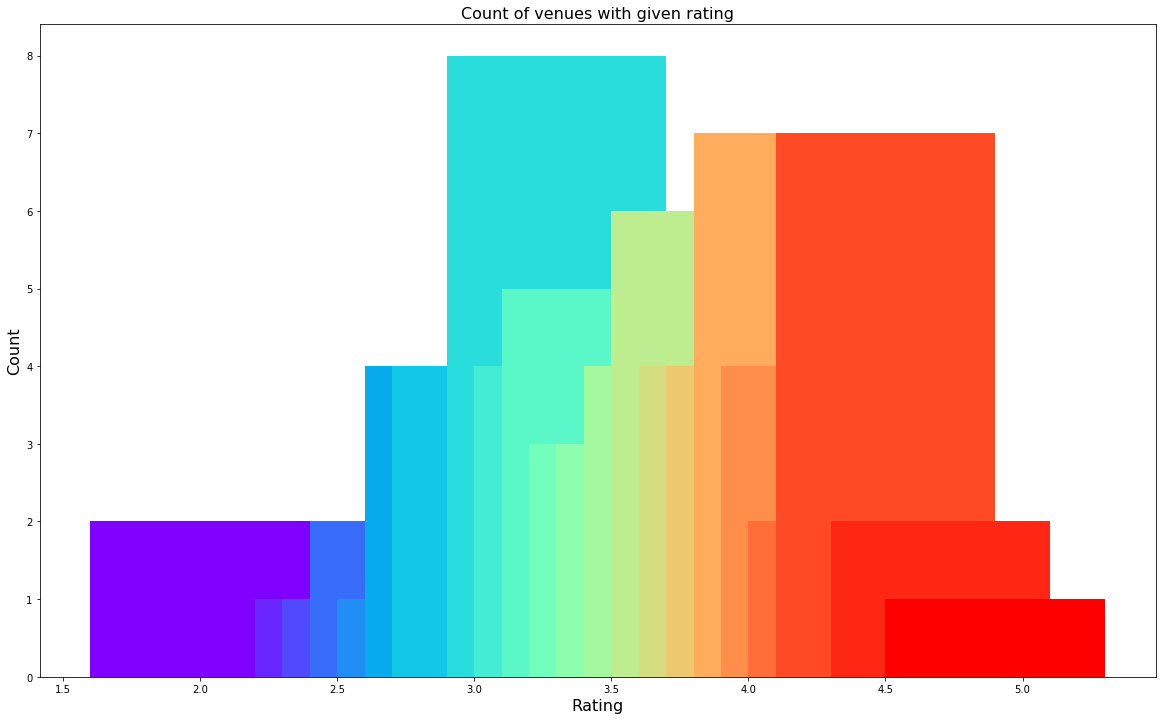

In [20]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

According to the plot above, it is clear that majority venues have their rating ranges from 3 to 3.7. 

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2:  'Low'
- 2 to 3:  'Okay'
- 3 to 4:  'Good'
- 4 to 5:  'Very Good'

In [21]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Let's map those bin plot onto the previous boston map! 

In [22]:
color_map = {'Low': 'darkblue', 'Okay': 'blue', 'Good': 'red', 'Very good': 'darkred'}

boston_map = folium.Map(location = [BOS_LAT, BOS_LNG], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(boston_map)  

boston_map.save("map/Venues Ratings.html")
boston_map

It appears that the North End and south end area has most 'excellent' venues, it should be on the top our recommendation list for visitors came to downtown Boston!

### Pricing
Take a look at the venues based on the price values. Here we have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which describe how expensive of this venue is when compared to all other venues.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price.

Text(0.5, 1.0, 'Count of venues with given average price')

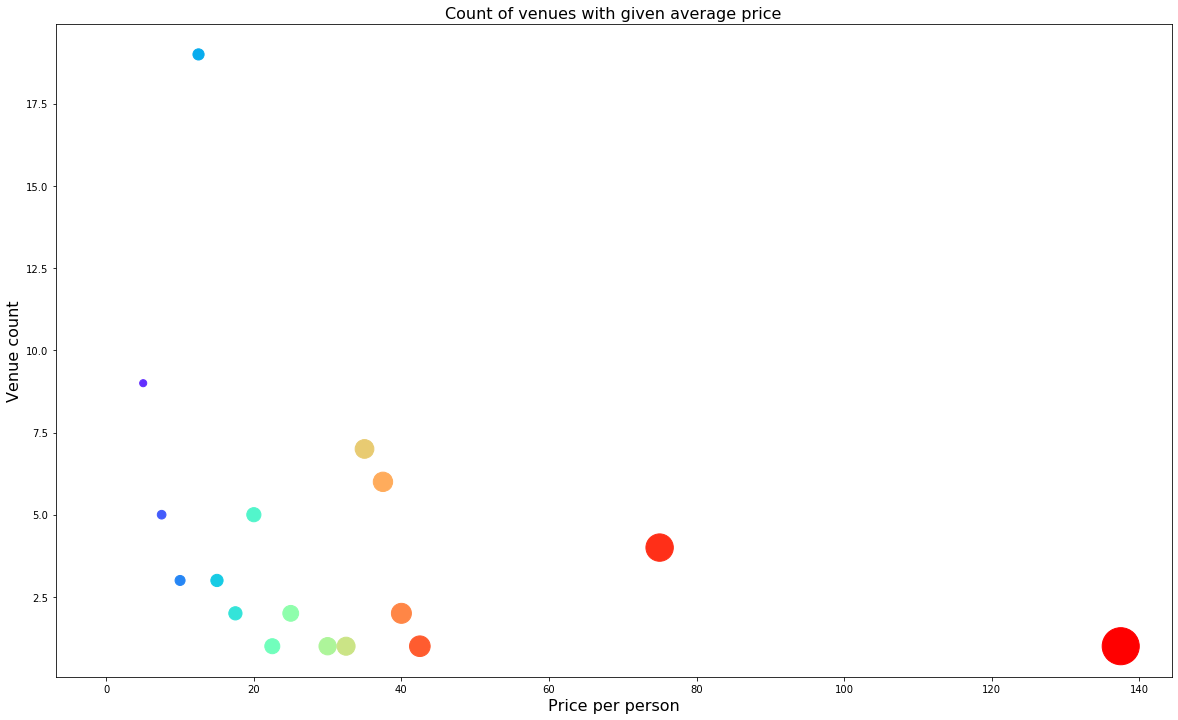

In [23]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price under 40 dollars. The under-20 should be people's most frequent choice.
There did have some luxury restaurant that cost over 100 dollars, mainly some luxury French restaurants.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. Let's map those price: the higher the price, the higher the redness.

In [24]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

boston_map = folium.Map(location = [BOS_LAT, BOS_LNG], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(boston_map)  

boston_map.save("map/Venues Prices.html")
boston_map

## Clustering 

In [ ]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

In [30]:
boston_map = folium.Map(location = [BOS_LAT, BOS_LNG], zoom_start = 13)
color_map = { 0: 'green', 1: 'red', 2:'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(boston_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(boston_map)

boston_map.save("map/Venues Clusters.html")
boston_map

In [31]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Seafood Restaurant,Neptune Oyster,42.3634,-71.0557,4.0,4.5,"63 Salem St, Boston 02113",35.0,Very good
1,0,Pizza Place,Regina Pizzeria,42.3654,-71.0569,4.0,4.5,"11 1/2 Thacher St, Boston 02113",37.5,Very good
2,0,Steakhouse,Ruth's Chris Steak House,42.3581,-71.0593,4.0,4.0,45 School Street 02108,35.0,Good
3,0,Seafood Restaurant,Ostra,42.3513,-71.0671,4.0,3.7,1 Charles Street South 02116,35.0,Good
4,0,Seafood Restaurant,Row 34,42.3496,-71.0473,4.0,3.9,"383 Congress Street, Boston 02210",25.0,Good
5,0,Gastropub,Brewer's Fork,42.3768,-71.0566,4.0,3.1,"7 Moulton St, Boston 02129",37.5,Good
6,0,French Restaurant,Bistro du Midi,42.3520,-71.0697,4.0,4.0,272 Boylston Street 02116,35.0,Good
7,0,Dive Bar,Delux Café & Lounge,42.3463,-71.0729,4.0,3.9,"100 Chandler Street, Boston 02116",37.5,Good
8,0,Italian Restaurant,Coppa,42.3434,-71.0686,4.0,4.3,"253 Shawmut Avenue, Boston 02118",30.0,Very good
9,0,Gastropub,The Butcher Shop,42.3436,-71.0717,4.0,4.2,552 Tremont Street. 02118,40.0,Very good


In [32]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 4.00 and rating spread around 3.94


In [33]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Belgian Restaurant,Saus,42.3613,-71.0570,3.0,4.2,"33 Union Street, Near Faneuil Hall 02108",15.0,Very good
1,1,Historic Site,Anthem Kitchen + Bar,42.3599,-71.0552,3.0,3.9,"101 S Market Street, Boston 02109",20.0,Good
2,1,Historic Site,Gourmet India,42.3600,-71.0562,1.0,3.0,1 Faneuil Hall Square,0.0,Okay
3,1,Gourmet Shop,Polcari's Coffee,42.3640,-71.0554,2.0,3.7,"105 Salem St, Boston 02113",12.5,Good
4,1,Pizza Place,Galleria Umberto,42.3638,-71.0544,2.0,4.7,"289 Hanover Street, Boston 02113",12.5,Very good
5,1,Sandwich Place,Sam Lagrassa's,42.3569,-71.0598,2.0,4.4,"44 Province Street, Boston 02108",12.5,Very good
6,1,Donut Shop,Kane's Hand-Crafted Donuts,42.3560,-71.0531,2.0,3.0,"90 Oliver Street, Boston 02110",10.0,Okay
7,1,Bakery,Bova's Bakery,42.3652,-71.0555,2.0,4.9,"134 Salem Street, Boston 02113",12.5,Very good
8,1,Pastry Shop,Mike's Pastry,42.3642,-71.0543,1.0,4.5,"300 Hanover Street, Boston 02113",7.5,Very good
9,1,Seafood Restaurant,James Hook & Co,42.3550,-71.0509,2.0,3.7,"440, Atlantic Ave, Financial District, Boston ...",12.5,Good


In [34]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.81 and rating spread around 3.66


In [35]:
result = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Gastropub,Ward 8,42.3655,-71.0585,4.0,2.8,90 North. Washington Street. 02114,75.0,Okay
1,2,Pub,The Warren Tavern,42.3744,-71.0630,4.0,4.3,2 Pleasant Street 02129,75.0,Very good
2,2,Steakhouse,Morton's The Steakhouse,42.3490,-71.0408,4.0,3.8,2 Seaport Lane 02210,137.5,Good
3,2,Italian Restaurant,Stella,42.3398,-71.0725,4.0,4.1,"1525 Washington Street, Boston 02118",75.0,Very good
4,2,Mexican Restaurant,El Centro,42.3386,-71.0760,4.0,2.6,"472 Shawmut Avenue, Boston 02118",75.0,Okay


In [36]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 3.52


## Results and Analysis

As the result shown from the above clusters, the average price doesn't positively related to the customer satisfaction(rating). Maybe the exquisite decoration of the restaurant will increase customers' expectation of food, thus results in a more serious evaluation.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.6. On the other hand, there are few venues which are high priced and not that satisfactory.

If you are not sure where to go, both North End and South End would be choices you won't regret. 

## Conclusion

The objective of this project is to help people find the places/venues according to the rating and pricing. The venues has been identified using Foursquare and Zomato API, the spots have been plotted onto the map, additionally, as suggested using the clustering algorithm, the North End and South End could be the best choice for visitors. 